# 一、实验结果比较图

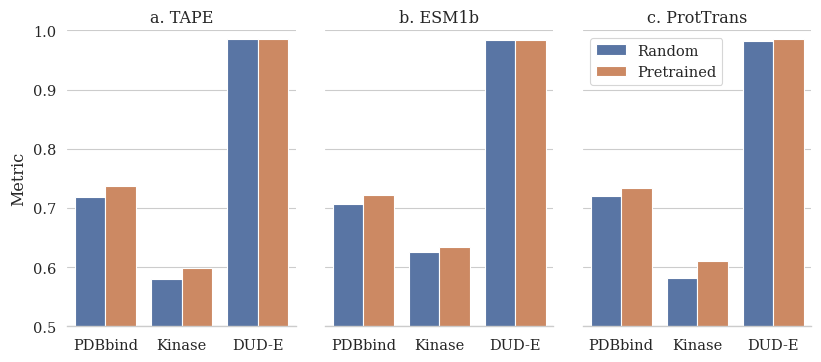

In [198]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

empirical_metrics = pd.read_csv("/data1/brian/PLM-PLI/empirical_results/empirical_metrics.csv")

sns.set(style="whitegrid", rc={"axes.grid.axis": "y", "axes.grid.which": "both", "grid.linewidth": 1.5})
# nature_colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#FAA43A', '#F1C232']
# nature_colors = ['#3D57A4', '#EC1D25']

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=nature_colors)
sns.set_context("paper", font_scale=1.2)
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 100

g = sns.catplot(
    data=empirical_metrics, x="task", y="metric", col="model", hue="scheme",
    kind="bar", height=4, aspect=.7
)
g.set_axis_labels("", "Metric")
g.set_titles("{col_name}")
g.set(ylim=(0.5, 1))
g.despine(left=True)

g.legend.remove()
plt.legend(loc='upper left')
plt.subplots_adjust(wspace=0.13)
plt.savefig("/data1/brian/PLM-PLI/paper_figs/Fig2.Empirical_Metrics.jpg", bbox_inches='tight', dpi=512)

# 二、表征空间可视化

Loading random data
Reducing dimension
Loading pretrained data
Reducing dimension
Loading finetuned data
Reducing dimension


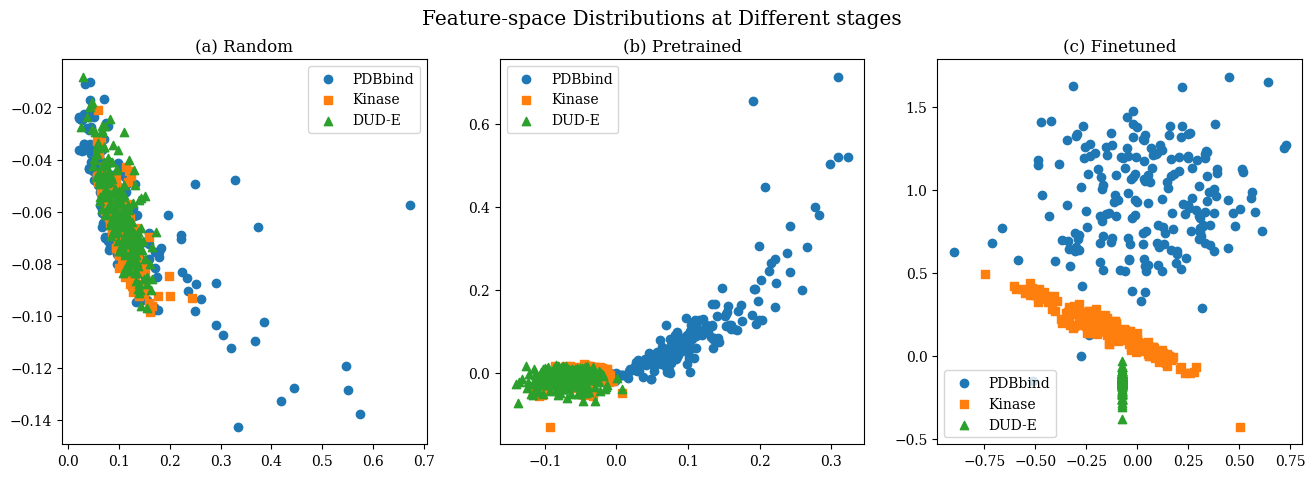

In [21]:
from sklearn.manifold import TSNE
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

def get_pkl_dir(embeddings_base, stage, dataset, model='tape'):
    for dir in os.listdir(embeddings_base):
        dir_splits = dir.split('_')
        dataset_, stage_, model_ = dir_splits[0], dir_splits[2], dir_splits[4]
        if dataset_==dataset and stage_==stage and model_==model:
            return os.path.join(embeddings_base, dir)

# 以一个模型为例
model = 'tape'
embeddings_base = "/data1/brian/PLM-PLI/empirical_results/embeddings/%s" % model
num_sampled = 200
SEED = 42

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titles = {'random': '(a) Random', 'pretrained': '(b) Pretrained', 'finetuned': '(c) Finetuned'}
for i, stage in enumerate(['random', 'pretrained', 'finetuned']):
    print("Loading {} data".format(stage))
    pdbbind_emb = pd.read_pickle(get_pkl_dir(embeddings_base, stage, 'PDBBind', model))
    kinase_emb = pd.read_pickle(get_pkl_dir(embeddings_base, stage, 'Kinase', model))
    dude_emb = pd.read_pickle(get_pkl_dir(embeddings_base, stage, 'DUDE', model))
    pdbbind_emb = pdbbind_emb.sample(frac=1, random_state=SEED).reset_index(drop=True).iloc[:num_sampled]
    kinase_emb = kinase_emb.sample(frac=1, random_state=SEED).reset_index(drop=True).iloc[:num_sampled]
    dude_emb = dude_emb.sample(frac=1, random_state=SEED).reset_index(drop=True).iloc[:num_sampled]
    pdbbind_emb = np.stack(pdbbind_emb['pro_emb'].tolist(), axis=0)
    kinase_emb = np.stack(kinase_emb['pro_emb'].tolist(), axis=0)
    dude_emb = np.stack(dude_emb['pro_emb'].tolist(), axis=0)

    # 使用t-SNE算法降维到2D空间
    print("Reducing dimension")
    tsne = TSNE(n_components=2, n_iter=250)
    all_embs = np.concatenate([pdbbind_emb, kinase_emb, dude_emb], axis=0)
    all_tsne = tsne.fit_transform(all_embs)
    pdbbind_tsne = all_embs[:num_sampled]
    kinase_tsne = all_embs[num_sampled: num_sampled*2]
    dude_tsne = all_embs[num_sampled*2: ]

    # 绘制数据集的scatter plot
    axes[i].scatter(pdbbind_tsne[:, 0], pdbbind_tsne[:, 1], label='PDBbind')
    axes[i].scatter(kinase_tsne[:, 0], kinase_tsne[:, 1], marker='s', label='Kinase')
    axes[i].scatter(dude_tsne[:, 0], dude_tsne[:, 1], marker='^', label='DUD-E')
    axes[i].set_title(titles[stage])
    axes[i].legend()

plt.subplots_adjust(wspace=0.2)
fig.suptitle("Feature-space Distributions at Different stages", size='x-large')
fig.savefig("/data1/brian/PLM-PLI/paper_figs/Fig3b.EmbeddingSpace_%s.jpg" % model, bbox_inches='tight', dpi=512)

# 三、时间比较

### 时间花销下降比例

In [163]:
import pandas as pd


def cal_datetime_ratio(rand_time, pt_time):
    """ 计算载入预训练微调相比于随机初始化微调的时间花销下降多少
    """
    rand_time_split = [int(t) for t in rand_time.split(':')]
    pt_time_split = [int(t) for t in pt_time.split(':')]
    rand_secs = rand_time_split[0]*(60**2) + rand_time_split[1]*60 + rand_time_split[2]
    pt_secs = pt_time_split[0]*(60**2) + pt_time_split[1]*60 + pt_time_split[2]
    cost_drop = (rand_secs - pt_secs) / rand_secs * 100
    return cost_drop

time_cost = pd.read_csv("/data1/brian/PLM-PLI/empirical_results/time_cost.csv")
cost_drop_ratios = pd.DataFrame(columns=['model', 'task', 'ratios'], index=range(9))
i = 0
for model, df in time_cost.groupby(time_cost['Model']):
    for task, sub_df in df.groupby(df.Task):
        cost_drop = cal_datetime_ratio(sub_df[sub_df['Scheme']=='Random']['Time'].values[0],
                                       sub_df[sub_df['Scheme']=='Pretrained']['Time'].values[0])
        cost_drop_ratios.iloc[i] = [model, task, cost_drop]
        i += 1
        
cost_drop_ratios.to_csv("/data1/brian/PLM-PLI/empirical_results/time_cost_drop_ratios.csv", index=False)
cost_drop_ratios

,model,task,ratios
0,ESM-1b,DUD-E,0.405873
1,ESM-1b,Kinase,1.57784
2,ESM-1b,PDBbind,3.970278
3,ProtTrans,DUD-E,0.634639
4,ProtTrans,Kinase,2.940527
5,ProtTrans,PDBbind,3.041698
6,TAPE,DUD-E,0.832408
7,TAPE,Kinase,2.107209
8,TAPE,PDBbind,0.190282


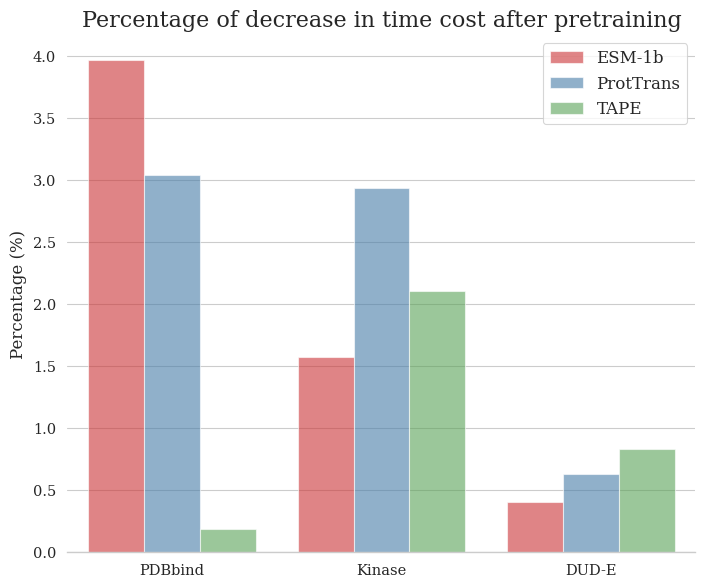

In [202]:
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=cost_drop_ratios, kind="bar",
    x="task", y="ratios", hue="model", dodge=5,
    errorbar="sd", palette="Set1", alpha=.6, height=6, aspect=1.2,
    order=['PDBbind', 'Kinase', 'DUD-E'], legend=False
)
g.despine(left=True)
g.set_axis_labels("", "Percentage (%)", fontsize=12)
plt.legend(loc='upper right', prop={'size': 12}, ncol=1)
plt.title("Percentage of decrease in time cost after pretraining", fontdict={'size': 16})
plt.savefig("/data1/brian/PLM-PLI/paper_figs/Fig3a.TimeDecrease.jpg", bbox_inches='tight', dpi=512)

### 拟合性能提升和时间花销下降的关系

In [149]:
perf_improve = pd.read_csv("/data1/brian/PLM-PLI/empirical_results/perf_improve.csv")
perf_time = pd.merge(cost_drop_ratios, perf_improve, on=['model', 'task'])
perf_time

,model,task,ratios,improve
0,ESM-1b,DUDE,0.405873,0.000
1,ESM-1b,Kinase,1.57784,2.420
2,ESM-1b,PDBbind,3.970278,2.690
3,ProtTrans,DUDE,0.634639,0.305
4,ProtTrans,Kinase,2.940527,4.980
5,ProtTrans,PDBbind,3.041698,1.940
6,TAPE,DUDE,0.832408,0.101
7,TAPE,Kinase,2.107209,2.930
8,TAPE,PDBbind,0.190282,2.650


In [150]:
from scipy.stats import spearmanr, pearsonr

(spearmanr(perf_time['improve'], perf_time['ratios']),
 pearsonr(perf_time['improve'], perf_time['ratios']))

(SignificanceResult(statistic=0.5166666666666667, pvalue=0.1543901209862251),
 PearsonRResult(statistic=0.6014377156207354, pvalue=0.08666632249436212))

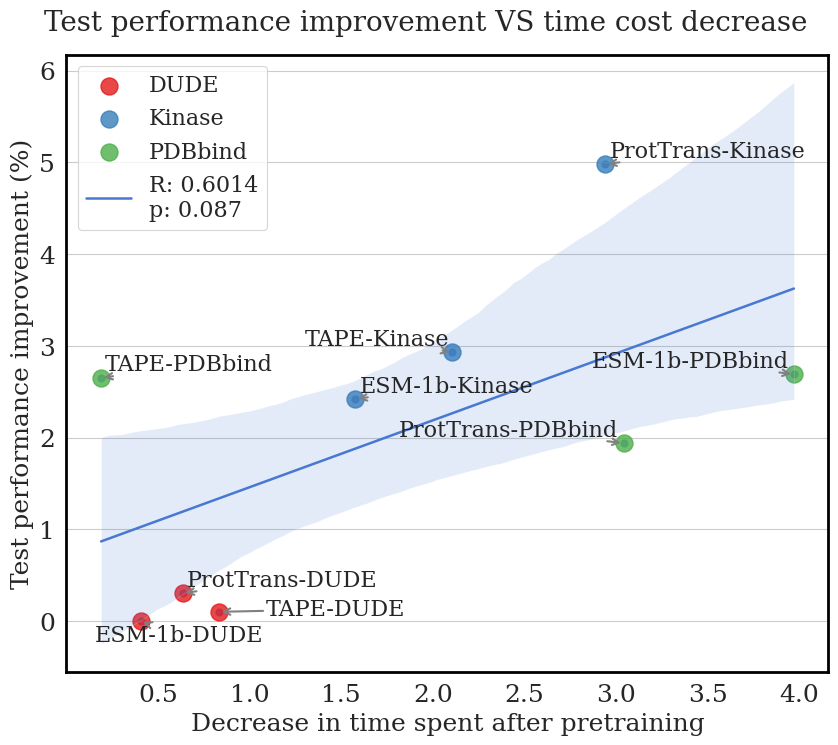

In [206]:
from adjustText import adjust_text

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['figure.dpi'] = 100
sns.set_palette("muted")
def fitting_plotter(transfer_stats, title_):
    # Linear regression fitting
    # spr, p = spearmanr(transfer_stats['improve'], transfer_stats['ratios'])
    spr, p = pearsonr(transfer_stats['improve'], transfer_stats['ratios'])

    # Scatter plot each points
    fgrid = sns.lmplot(x="ratios", y="improve", data=transfer_stats, height=7, aspect=6/5, fit_reg=False,
                        legend=False, scatter_kws={"s": 150}, hue='task', palette='Set1', ci=20)
    ax = sns.regplot(x="ratios", y="improve", data=transfer_stats, scatter_kws={"zorder":-1},
                    line_kws={'label': 'R: {:.4f}\np: {:.3f}'.format(spr, p)}, ci=90)
    # Annotate point
    texts = []
    for i, point in transfer_stats.iterrows():
        texts.append(plt.text(point['ratios'], point['improve'], point['model_task'], fontdict={'size': 16}))
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey', lw=1.5))

    # Add bbox via spine drawing
    for loc, spine in ax.spines.items(): # spine of left, right, bottom and top
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(2)
    # Label axis and show legend
    ax.set_xlabel("Decrease in time spent after pretraining", size=18)
    ax.set_ylabel("Test performance improvement (%)", size=18)
    ax.tick_params(axis='both', labelsize=18)

    plt.legend(loc='upper left', prop={'size': 16}, ncol=1)
    plt.suptitle(title_, size=20, y=1.04)


transfer_stats = perf_time.copy() # [['ratios', 'improve', 'model']]
transfer_stats['model_task'] = perf_time['model']+'-' + perf_time['task']
transfer_stats[['ratios', 'improve']] = transfer_stats[['ratios', 'improve']].astype(np.float64)
fitting_plotter(transfer_stats, 'Test performance improvement VS time cost decrease')
plt.savefig("/data1/brian/PLM-PLI/paper_figs/Fig3b.PerformanceVSTime.jpg", bbox_inches='tight', dpi=512)